In [300]:
# # Smart Cart Feature Engineering
# **Data Source**: Coles product catalog sample  
# **Objective**: Preprocess raw product data and extract features for recommendation modeling
# %%
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import re
from datetime import datetime, timedelta
import random
import io
import matplotlib.pyplot as plt
import seaborn as sns
import uuid
from collections import defaultdict


In [301]:
# ## 1. Load and Inspect Data
# Load the dataset
df = pd.read_csv('ScrappedData.2025_05_15_182013_Coles_All.csv')
print(f"Raw data shape: {df.shape}")
print("\nDataFrame Info:")
df.info()

Raw data shape: (28412, 10)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28412 entries, 0 to 28411
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   _id           28412 non-null  object 
 1   product_code  28412 non-null  int64  
 2   category      28412 non-null  object 
 3   item_name     28412 non-null  object 
 4   best_price    28412 non-null  float64
 5   item_price    28412 non-null  float64
 6   unit_price    27629 non-null  object 
 7   special_text  2058 non-null   object 
 8   promo_text    3947 non-null   object 
 9   link          28412 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 2.2+ MB


In [302]:
# 2. Data Pre-processing for Feature Extraction

# Step 2a: Dropping unnecessary columns as they are either empty or not useful for the model.
df = df.drop(columns=['special_text', 'promo_text', 'link'], axis=1)

# --- Data Cleaning Steps ---
# Drop any duplicate product codes to ensure a unique index for the map
df.drop_duplicates(subset=['product_code'], keep='first', inplace=True)

# Convert 'best_price' and 'item_price' to numeric before cleaning
df['best_price'] = pd.to_numeric(df['best_price'], errors='coerce')
df['item_price'] = pd.to_numeric(df['item_price'], errors='coerce')

# Ensure item_price is valid and not less than best_price
# We use np.where to apply this condition across the DataFrame.
df['item_price'] = np.where(
    (df['item_price'] <= df['best_price']) | (df['item_price'].isnull()),
    df['best_price'],
    df['item_price']
)

In [303]:
df.isna().sum()

_id               0
product_code      0
category          0
item_name         0
best_price        0
item_price        0
unit_price      751
dtype: int64

In [304]:
# Drop rows where unit_price is null
df = df.dropna(subset=['unit_price'])

In [305]:
df.isna().sum()

_id             0
product_code    0
category        0
item_name       0
best_price      0
item_price      0
unit_price      0
dtype: int64

In [306]:
# Step 2b: Extracting numerical and categorical features from `unit_price`.

def extract_price_and_unit(unit_price_str):
    """Extracts price and unit from unit_price, handling floats/NaN."""
    if pd.isna(unit_price_str):
        return None, None
    
    # Convert to string if it's a number/float
    unit_price_str = str(unit_price_str)
    
    # Extract price (e.g., "$2.90" → 2.90)
    price_match = re.search(r'\$([\d\.]+)', unit_price_str)
    price = float(price_match.group(1)) if price_match else None
    
    # Extract unit (e.g., "per 100g" → "100g")
    unit_match = re.search(r'per\s*(.*)', unit_price_str, re.IGNORECASE)
    unit = unit_match.group(1).strip().lower() if unit_match else None
    
    return price, unit

In [307]:
# Apply the function to the `unit_price` column and assign the results to new columns
df[['unit_price_value', 'unit_of_measure']] = df['unit_price'].apply(
    lambda x: pd.Series(extract_price_and_unit(x))
)

unique_units = df["unit_of_measure"].unique()
print("Unique units in dataset:", unique_units)

Unique units in dataset: ['1ea' '100g' '1l' '1kg' '100ml' '100ea' '1m' '10g' '10ml']


In [308]:
print(df.head())

                        _id  product_code             category  \
0  6825a3c58951f0bfbd089c41        112638  PICNIC POOL BBQ ACC   
1  6825a3c58951f0bfbd089c42       2395329           MEAL BASES   
2  6825a3c58951f0bfbd089c43       3445932       INFANT NAPPIES   
3  6825a3c58951f0bfbd089c44       6398737       INFANT NAPPIES   
4  6825a3c58951f0bfbd089c45       5275072           MEAL BASES   

                              item_name  best_price  item_price  \
0                          Firelighters        3.95         6.0   
1          Butter Chicken Cooking Sauce        3.60         4.9   
2  Premium Nappy Pants Size 5 (13-18Kg)       15.00        18.5   
3    Premium Nappy Pants Size 7 (17+Kg)       15.00        18.5   
4          Sugo Passata Basil & Parsley        3.80         4.3   

       unit_price  unit_price_value unit_of_measure  
0   $0.16 per 1ea              0.16             1ea  
1  $0.74 per 100g              0.74            100g  
2   $0.58 per 1ea              0.58   

In [309]:
# Step 2c: Standardizing units and calculating a new base price.
# This function will convert all units to a common base (grams for weight, mL for volume)
# and calculate a standardized price per 100g or 100ml.
def standardize_to_base_price(row):
    unit_string = str(row['unit_of_measure']).lower()
    unit_price = row['unit_price_value']

    if pd.isna(unit_string) or pd.isna(unit_price):
        return None

    try:
        if "kg" in unit_string:
            # Price per 1kg -> price per 100g
            return unit_price / 10
        elif "g" in unit_string:
            # Price per 100g -> no change
            return unit_price
        elif "l" in unit_string or "litre" in unit_string:
            # Price per 1L -> price per 100mL
            return unit_price / 10
        elif "ml" in unit_string:
            # Price per 100mL -> no change
            return unit_price
        elif "ea" in unit_string or "each" in unit_string:
            # For count-based items, we'll assume a standard weight per item for comparison
            # This is a simplification; in a real model, this would be more specific.
            # Let's assume 1 item is roughly 100g for this sample data.
            return unit_price
        else:
            return unit_price
    except (AttributeError, ValueError):
        return None

In [310]:
# Calculate the discount percentage for each item.
df['discount_percentage'] = (df['item_price'] - df['best_price']) / df['item_price']

In [311]:
df['base_unit_price'] = df.apply(standardize_to_base_price, axis=1)
# Drop the original 'unit_price' column and the now-redundant 'unit_of_measure' column.
df = df.drop(columns=['unit_price'])

In [312]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18079 entries, 0 to 28401
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   _id                  18079 non-null  object 
 1   product_code         18079 non-null  int64  
 2   category             18079 non-null  object 
 3   item_name            18079 non-null  object 
 4   best_price           18079 non-null  float64
 5   item_price           18079 non-null  float64
 6   unit_price_value     18079 non-null  float64
 7   unit_of_measure      18079 non-null  object 
 8   discount_percentage  18079 non-null  float64
 9   base_unit_price      18079 non-null  float64
dtypes: float64(5), int64(1), object(4)
memory usage: 1.5+ MB


In [313]:
df.head(10)

,_id,product_code,category,item_name,best_price,item_price,unit_price_value,unit_of_measure,discount_percentage,base_unit_price
0,6825a3c58951f0bfbd089c41,112638,PICNIC POOL BBQ ACC,Firelighters,3.95,6.0,0.16,1ea,0.341667,0.16
1,6825a3c58951f0bfbd089c42,2395329,MEAL BASES,Butter Chicken Cooking Sauce,3.60,4.9,0.74,100g,0.265306,0.74
2,6825a3c58951f0bfbd089c43,3445932,INFANT NAPPIES,Premium Nappy Pants Size 5 (13-18Kg),15.00,18.5,0.58,1ea,0.189189,0.58
3,6825a3c58951f0bfbd089c44,6398737,INFANT NAPPIES,Premium Nappy Pants Size 7 (17+Kg),15.00,18.5,0.68,1ea,0.189189,0.68
4,6825a3c58951f0bfbd089c45,5275072,MEAL BASES,Sugo Passata Basil & Parsley,3.80,4.3,0.54,100g,0.116279,0.54
5,6825a3c58951f0bfbd089c46,8925425,MEDICINAL PRODUCTS,Spa Detox Patch 10pk,5.95,11.9,0.60,1ea,0.500000,0.60
6,6825a3c58951f0bfbd089c47,3445954,INFANT NAPPIES,Premium Nappy Pants Size 6 (15-20Kg),15.00,18.5,0.63,1ea,0.189189,0.63
7,6825a3c58951f0bfbd089c48,3445943,INFANT NAPPIES,Premium Nappy Pants Size 4 (10-15Kg),15.00,18.5,0.52,1ea,0.189189,0.52
8,6825a3c58951f0bfbd089c49,6344308,ENERGY/SPORT/ICEDTEA,Ice Tea Peach Tea Iced Tea Bottle,3.60,6.0,2.40,1l,0.400000,0.24
9,6825a3c58951f0bfbd089c4a,1167872,PROTEIN & MEALS,Frozen Cheese Macaroni,3.80,4.5,1.46,100g,0.155556,1.46


In [314]:
# Step 2e: Print the head of the pre-processed DataFrame to see the results.
print("Pre-processed DataFrame saved to preprocessed_data.csv.")
# You can now save this combined DataFrame to a CSV file for future use
df.to_csv('preprocessed_data.csv', index=False)

Pre-processed DataFrame saved to preprocessed_data.csv.


In [315]:
# Step 2. Generating transactions 
df_products = df.copy()
# Parameters and lists for generating synthetic transactions
num_users = 1000
num_transactions = 100000
start_date = datetime(2024, 1, 1)
end_date = datetime(2025, 7, 31)
product_info_map = df_products.set_index('product_code')[['best_price', 'item_price', 'category']].to_dict('index')

In [316]:

def simulate_transactions_improved(num_users = 1000, start_date = datetime(2024, 1, 1), end_date = datetime(2025, 7, 31)):
    
    # Create product popularity tiers
    product_codes = df_products['product_code'].unique()
    num_products = len(product_codes)

    high_tier = random.sample(list(product_codes), k=int(num_products * 0.2))
    remaining_products = list(set(product_codes) - set(high_tier))
    medium_tier = random.sample(remaining_products, k=int(num_products * 0.3))
    low_tier = list(set(remaining_products) - set(medium_tier))

    product_tiers = {
        'high': high_tier,
        'medium': medium_tier,
        'low': low_tier
    }

    # Create user segments
    user_ids = [f'user_{i+1}' for i in range(num_users)]
    loyal_users = random.sample(user_ids, k=int(num_users * 0.2))
    frequent_users = random.sample(list(set(user_ids) - set(loyal_users)), k=int(num_users * 0.3))
    casual_users = list(set(user_ids) - set(loyal_users) - set(frequent_users))
        

    # Generate transactions with more realistic patterns
    transactions = []
    user_purchase_history = defaultdict(list)

    # We will simulate a fixed number of transactions per user type
    # to better control the purchase distribution.
    for user in user_ids:
        # Determine user type and how many transactions they will make
        if user in loyal_users:
            user_type = 'loyal'
            # Loyal users do more transactions and re-purchase more often
            num_user_transactions = random.randint(500, 1000)
            re_purchase_prob = 0.6
        elif user in frequent_users:
            user_type = 'frequent'
            num_user_transactions = random.randint(200, 500)
            re_purchase_prob = 0.4
        else:
            user_type = 'casual'
            num_user_transactions = random.randint(10, 200)
            re_purchase_prob = 0.1

        for _ in range(num_user_transactions):
            product_code = None
            
            # Decide whether to re-purchase an old product or buy a new one
            if random.random() < re_purchase_prob and user_purchase_history[user]:
                product_code = random.choice(user_purchase_history[user])
            else:
                # Select product based on popularity tier
                tier = np.random.choice(
                    ['high', 'medium', 'low'],
                    p=[0.6, 0.3, 0.1]
                )
                product_code = random.choice(product_tiers[tier])
                
            # Add to purchase history
            user_purchase_history[user].append(product_code)

            # Get product info and calculate price
            product_info = product_info_map.get(product_code)
            if product_info:
                quantity = random.randint(1, 5 if tier == 'high' else 3)
                
                if user_type == 'loyal':
                    price = product_info['best_price'] * (1 - random.uniform(0, 0.1))
                else:
                    price = product_info['item_price'] * (1 + random.uniform(0, 0.05))
                
                random_date = start_date + timedelta(days=random.randint(0, (end_date - start_date).days))
                transactions.append([user, product_code, random_date, price])
    
    transactions_df = pd.DataFrame(transactions, columns=['user_id', 'product_code', 'transaction_date', 'transaction_price'])   
    
    # Merge with product data
    transactions_df = pd.merge(transactions_df, df_products, on='product_code', how='left')
     # Generate a unique ID
    unique_id = uuid.uuid4().hex[:8]  # Shortened UUID
    filename = f'transactions_{unique_id}.csv'

    # Save the file
    transactions_df.to_csv(filename, index=False)

    return [transactions_df, unique_id]

In [317]:
# --- NEW: Function to check data simulation bias with a single plot ---
def check_data_simulation(simulated_data, unique_id, save_figure = True):
    """
    Generates a single figure with four subplots to visualize data bias.
    
    This function creates histograms and bar plots to analyze the distribution of
    transactions across users, products, months, and days of the week.
    
    Args:
        simulated_data (pd.DataFrame): The DataFrame containing simulated transaction data.
    """
    plt.style.use('ggplot')
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle('Advanced Data Bias Check', fontsize=20)
    
    # User Bias: Distribution of transactions per user
    user_transactions_count = simulated_data['user_id'].value_counts()
    
    # Product Bias: Distribution of purchases per product
    product_popularity = simulated_data['product_code'].value_counts()

    # Create a DataFrame for a nice, two-row table
    stats_df = pd.DataFrame({
        'Transactions per User': user_transactions_count.describe(),
        'Purchases per Product': product_popularity.describe()
    })
    
    print("\n--- Descriptive Statistics for Reporting ---")
    print(stats_df.T.round(2)) # Transpose and round for a clean table
    
    sns.histplot(user_transactions_count, bins=50, kde=True, ax=axes[0, 0])
    axes[0, 0].set_title('Distribution of Transactions per User')
    axes[0, 0].set_xlabel('Number of Transactions')
    axes[0, 0].set_ylabel('Number of Users')
    
    
    sns.histplot(product_popularity, bins=50, kde=True, ax=axes[0, 1])
    axes[0, 1].set_title('Distribution of Purchases per Product')
    axes[0, 1].set_xlabel('Number of Purchases')
    axes[0, 1].set_ylabel('Number of Products')
    
    # Temporal Bias: Transactions by month
    simulated_data['month'] = simulated_data['transaction_date'].dt.month_name()
    sns.countplot(data=simulated_data, x='month', 
                  order=['January', 'February', 'March', 'April', 'May', 'June', 'July'], 
                  ax=axes[1, 0])
    axes[1, 0].set_title('Total Transactions by Month')
    axes[1, 0].set_xlabel('Month')
    axes[1, 0].set_ylabel('Number of Transactions')
    
    # Temporal Bias: Transactions by day of the week (New Plot)
    simulated_data['day_of_week'] = simulated_data['transaction_date'].dt.day_name()
    sns.countplot(data=simulated_data, x='day_of_week', 
                  order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 
                  ax=axes[1, 1])
    axes[1, 1].set_title('Total Transactions by Day of the Week')
    axes[1, 1].set_xlabel('Day of the Week')
    axes[1, 1].set_ylabel('Number of Transactions')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    if save_figure:
        # Generate a unique filename if none provided
        filename = f"data_bias_check_{unique_id}.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Figure saved as: {filename}")
    else:
        plt.show()


--- Running 10 Simulations to Check Stability ---

--- Running Simulation #1/10 ---

--- Descriptive Statistics for Reporting ---
                        count    mean     std   min    25%    50%     75%  \
Transactions per User   100.0  302.82  263.36  10.0  91.75  208.5  436.25   
Purchases per Product  8214.0    3.69    5.77   1.0   1.00    2.0    4.00   

                         max  
Transactions per User  961.0  
Purchases per Product  134.0  
Figure saved as: data_bias_check_1bc53766.png

--- Simulation stability check complete. ---


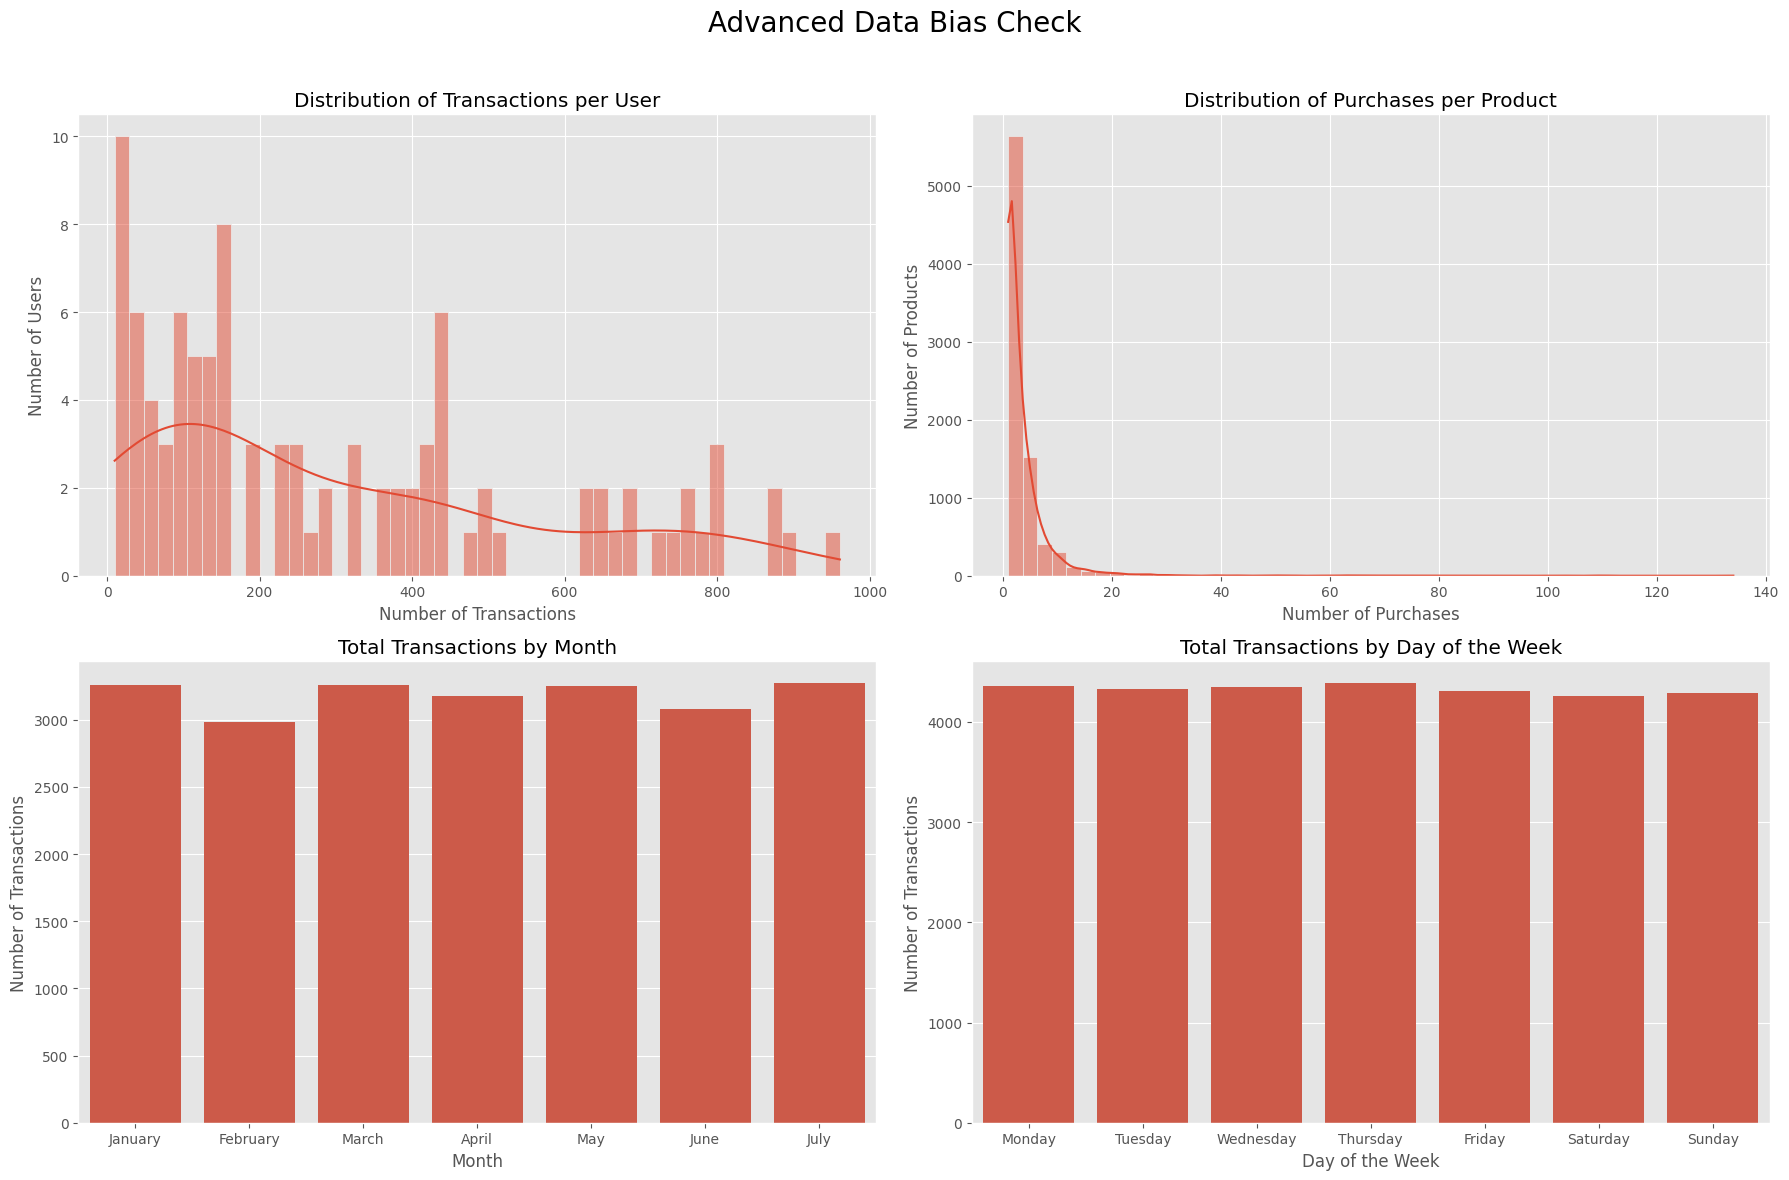

In [318]:
# --- Main execution block to test simulation stability ---
print("\n--- Running 10 Simulations to Check Stability ---")
for i in range(1, 2):
    print(f"\n--- Running Simulation #{i}/10 ---")
    
    # Run the transaction simulation
    [simulated_data, unique_id] = simulate_transactions_improved(num_users = 100, start_date = datetime(2024, 1, 1), end_date = datetime(2025, 7, 31))
    #[simulated_data, unique_id] = simulate_transactions()    
    # Run the bias check on the simulated data
    check_data_simulation(simulated_data, unique_id)

print("\n--- Simulation stability check complete. ---")


In [321]:
colmuns = ['user_id', 'product_code', 'transaction_date', 'transaction_price', 'category', 'item_name', 'discount_percentage', 'month', 'day_of_week']
simulated_data [colmuns].head()

,user_id,product_code,transaction_date,transaction_price,category,item_name,discount_percentage,month,day_of_week
0,user_1,9109880,2024-08-19,4.507670,BISCUITS & COOKIES,Breakfast Biscuits Milk & Cereals 6 Pack,0.0,August,Monday
1,user_1,4970213,2025-02-09,2.584744,BARS GUM POCKET PACK,Intense Mint Sugar Free Chewing Gum,0.0,February,Sunday
2,user_1,3220127,2024-11-13,14.023320,BRUSHWARE,Ultra glide Metallic Ironing Board Cover Pattern,0.0,November,Wednesday
3,user_1,8877173,2024-09-22,8.128872,CHILLED DESSERTS,Multi Flavoured Classic Yoghurt 12 x100g,0.0,September,Sunday
4,user_1,7207404,2025-02-16,14.027454,PROTEIN & MEALS,Atlantic Salmon With Lemon Pepper,0.0,February,Sunday
